# Data analysis with ibmdbpy and Db2 Warehouse - Part 1: Preprocessing

This notebook shows how to explore and preprocess data with ibmdbpy with a point of interest recommendation use case.

___

### Accelerate Python analytics with in-database processing by using ibmdbpy and IBM Db2 Warehouse

The ibmdbpy project provides access to in-database algorithms in IBM Db2 Warehouse through a Python interface for data manipulation. It accelerates Python analytics by seamlessly pushing operations written in Python into the underlying database for execution, thereby benefitting from in-database performance-enhancing features, such as columnar storage and parallel processing. For more details about ibmdbpy, please refer to the [documentation](https://pythonhosted.org/ibmdbpy/index.html) and to the dedicated [Git repository](https://github.com/ibmdbanalytics/ibmdbpy/tree/master/ibmdbpy). This notebook provides you with an overview of ibmdbpy functionalities through a tourism use case. 


__About this notebook__

In the "Museums" notebook series, you get deeper insights about how to perform in-database analytics with ibmdbpy.
Our use case: tourism in the United States. Imagine you have designed a tourism app and want to recommand activities or places to users according to their location, taste and a set of other constraints. Ibmdbpy spatial extension enables you to efficiently query your database for real-time recommandation. The two notebooks of this series respectively cover the following topics:

1. Open and preprocess data: here you are!
2. Recommend a Point of Interest in the US: [geospatial recommandation notebook](./ibmdbpy_Museums_DataAnalysis_2-geospatial.ipynb)


__Prerequisites__
* Db2 account: see [IBM Cloud](https://cloud.ibm.com/login) or [Db2 Warehouse](https://www.ibm.com/support/knowledgecenter/en/SSCJDQ/com.ibm.swg.im.dashdb.kc.doc/welcome.html)
* Db2 driver: learn more on [IBM Knowledge Center](https://www.ibm.com/support/knowledgecenter/en/SSFMBX/com.ibm.swg.im.dashdb.doc/connecting/connect_applications_by_type.html) and see [IBM Support](https://www.ibm.com/support/pages/db2-jdbc-driver-versions-and-downloads)
* Having installed the [ibmdbpy](https://pypi.org/project/ibmdbpy/) python library with pip: 
> pip install ibmdbpy 
* Optional dependency for JDBC is the [jaydebeapi](https://pypi.org/project/JayDeBeApi/) library. Run the following command to install ibmdbpy, as well as the dependencies for the JDBC feature:
> pip install ibmdbpy[jdbc]
* The [museums.csv](https://www.kaggle.com/imls/museum-directory/data) dataset.

Note: the museums dataset we use in this notebook has been published under the licence CC0 1.0 Universal (CC0 1.0) /
Public Domain Dedication (see [source](https://www.kaggle.com/imls/museum-directory/data)).


__Contents__

__1. Get started__
* Imports 
* Establish JDBC connection
* Load the data

__2. Explore the data__

* Compute basic statistics
* Clean the dataand select features 

__3. Convert the data into an IdaGeoDataFrame for geospatial analysis__

* Create an IdaGeoDataFrame with an SQL query
* Map MuseumType to numerical categories
* Notes about IdaGeoDataFrames
* Visualization

## 1. Get started

First, we make the necessary imports and establish a connection to Db2 Warehouse. Then we load the data using ibmdbpy. You will see how ibmdbpy offers a user-friendly syntax which makes it easy to handle for Pandas lovers. Many functionalities keep the same name (e.g. head, tail, describe) or structure (e.g. selection, filtering). 

But ibmdbpy is not just another data science library: it has been designed for in-database analytics, seemlessly bringing the code inside Db2 for efficient query execution, while enabling you to work with a familiar Python environment. 

By using the verbosity mode you are able to see in real time the query executed inside Db2: useful to keep control over data manipulation and for trouble shooting!

__Imports__

Jaydebeapi is used in order to establish a JDBC connection. We load the necessary classes of ibmdbpy. Pandas, numpy, seaborn and matplotlib are used for data visualization.

In [1]:
# packages for Db2 connection, ibmdbpy classes
from ibmdbpy import IdaDataBase, IdaDataFrame, IdaGeoDataFrame

# visualization and data transformation
import pandas
import geopandas
import numpy as np
from shapely.geometry import Point
import seaborn as sns
import matplotlib.pyplot as plt

__Establish JDBC connection__

The JDBC connection is based on a Java Virtual Machine, so it is available on every machine that can run Java. In ibmdbpy, users can choose to use JDBC to connect to a remote Db2 instance. 

You have to enter your own credentials in the following cell.

In [2]:
#Enter the values for you database connection
dsn_database = "___" # e.g. "BLUDB"
dsn_hostname = "___" # e.g.: "abc.url.example"
dsn_port = "___"    # e.g. "50000"
dsn_uid = "___"     # e.g. "db2_1234"
dsn_pwd = "___"     # e.g. "zorglub"

In [3]:
#Establish connection
connection_string='jdbc:db2://'+dsn_hostname+':'+dsn_port+'/'+dsn_database+':user='+dsn_uid+';password='+dsn_pwd+";" 
idadb=IdaDataBase(dsn=connection_string, verbose = False)

The connection is now established! If you leave this notebook open for a while, it might get closed even if your Kernel does not die. No problem! Your variables are not lost, it is only the connection that has been interrupted. Just run the following to reconnect:

> idadb.reconnect()

In the end of this notebook, you will close the connection by running:

> idadb.close()

Note that you can modify the verbosity (i.e. whether the underlying SQL queries executed when calling the python functions are printed) with the `verbose` option in the definition of the IdaDataBase object above.

By default the environment variable `AUTOCOMMIT` is then set to True, which means that every SQL statement which is submitted through the connection is executed within its own transaction and then committed implicitly. When you close the connection to Db2, if the environment variable `AUTOCOMMIT` is set to False, then all changes after the last explicit commit are discarded. 

__Load the data__

We load the csv data locally as a Pandas DataFrame, then save it to a Db2 table and open it as an IdaDataFrame inside this notebook.

Please use this [link](https://www.kaggle.com/imls/museum-directory/data) to download the dataset if you have not already done so.

<font color=blue>Note on column names</font>

We rename columns for convenience: we remove spaces and add underscores for clarity. IdaDataFrames which are displayed in the notebooks are views of remote tables. So column names should be SQL compatible.

In the cells below, we check if a table with the same name already exists in the database. If so, you may want to overwrite the existing table. Otherwise, you have to modify table names to avoid any conflict.

<font color=green>*The dataset must be in your current working directory under the name museums.csv. Otherwise, change the path in the cell bellow.*</font>


In [4]:
## museums.csv must be put in your current working directory

# new names without spaces
dico = {'Museum ID': 'MuseumID', 
        'Museum Name':'MuseumName', 
        'Legal Name':'LegalName', 
        'Alternate Name':'AlternateName',
        'Museum Type':'MuseumType', 
        'Institution Name':'InstitutionName',
        'Street Address (Administrative Location)':'StreetAddress_Admin',
        'City (Administrative Location)':'City_Admin', 
        'State (Administrative Location)':'State_Admin',
        'Zip Code (Administrative Location)':'ZipCode_Admin',
        'Street Address (Physical Location)':'StreetAddress_Physical', 
        'City (Physical Location)':'City_Physical',
        'State (Physical Location)':'State_Physical',
        'Zip Code (Physical Location)':'ZipCode_Physical',
        'Phone Number':'PhoneNumber', 
        'Locale Code (NCES)':'LocaleCode_NCES',
        'County Code (FIPS)':'CountyCode_FIPS', 
        'State Code (FIPS)':'StateCode_FIPS', 
        'Region Code (AAM)':'RegionCode_AAM',
        'Employer ID Number':'EmployerID', 
        'Tax Period':'TaxPeriod'}

def create_museums(clear_existing):    
    # Read the csv file with pandas
    df = pandas.read_csv('museums.csv', low_memory=False)
    # DtypeWarning: Columns (9,14,21) have mixed types. => Specify dtype option on import or set low_memory=False.
    print('Checking column names')
    print(df.columns)
    # Rename columns
    print('Renaming columns')
    print(df.columns)
    df = df.rename(columns=dico)
    # Create the table in Db2
    museums = idadb.as_idadataframe(df, "MUSEUMS", clear_existing = clear_existing)
    print('Table MUSEUMS successfully created!')
    return museums

In [5]:
if idadb.exists_table('MUSEUMS'):
    print('The MUSEUMS table already exists.')
    print('Would you like to overwrite it?')
    ans = input('[y/n] ')
    if ans == 'y':
        museums = create_museums(clear_existing = True)
    if ans == 'n':
        print("Alright. Let's keep the existing one.")
        museums = IdaDataFrame(idadb, "MUSEUMS")
else:
    print('No MUSEUMS table exists in your database.')
    print('The MUSEUMS table is going to be written into Db2.')
    museums = create_museums(clear_existing = False)

The MUSEUMS table already exists.
Would you like to overwrite it?
[y/n] n
Alright. Let's keep the existing one.


Note that here our dataset is relatively small, so splitting it into many chunks (104 chunks of 320 rows with ibmdbpy here) is not very efficient... But this is very useful when you are processing your own real-world, mission-critical data which consists in tens of millions of rows! 

* Finally, take a look at the data

In [6]:
# Similarly to Pandas DataFrames, ibmdbpy IdaDataFrames have a 'head' method
museums.head()
# Column names successfully inferred and modified

,MuseumID,MuseumName,LegalName,AlternateName,MuseumType,InstitutionName,StreetAddress_Admin,City_Admin,State_Admin,ZipCode_Admin,...,StateCode_FIPS,RegionCode_AAM,EmployerID,TaxPeriod,Income,Revenue,MUSEUMTYPE_CAT_0,MUSEUMTYPE_CAT_1,MUSEUMTYPE_CAT_2,MUSEUMTYPE_CAT_3
0,8400100001,WESTERVELT-WARNER MUSEUM OF AMERICAN ART,WESTERVELT WARNER MUSEUM,None,2,None,8316 MOUNTBATTEN RD NE,TUSCALOOSA,AL,35406,...,1.0,3,None,NaN,NaN,NaN,None,None,None,None
1,8400100002,U. S. ARMY AVIATION MUSEUM,ARMY AVIATION MUSEUM FOUNDATION INC,None,2,None,6000 NOVOSEL ST,FORT RUCKER,AL,36362,...,1.0,3,630589651,201409.0,406078.0,256287.0,None,None,None,None
2,8400100004,U.S. SPACE & ROCKET CENTER,U.S. SPACE & ROCKET CENTER FOUNDATION,None,2,None,ONE TRANQUILITY BASE,HUNTSVILLE,AL,35807,...,1.0,3,631265839,201309.0,2022595.0,2022595.0,None,None,None,None
3,8400100005,WELLBORN MUSCLECAR MUSEUM,WELLBORN MUSCLECAR MUSEUM,None,2,None,124 BROAD ST,ALEXANDER CITY,AL,35010,...,1.0,3,None,NaN,NaN,NaN,None,None,None,None
4,8400100007,USS ALABAMA BATTLESHIP,USS ALABAMA BATTLESHIP COMMISSION,None,2,None,2703 BATTLESHIP PKWY,SPANISH FORT,AL,36527,...,1.0,3,None,NaN,NaN,NaN,None,None,None,None


Ibmdbpy has a Pandas like behavior but of course it has something more than Pandas: it has been optimized to bring code to the database instead of waiting for the data to come. Let's explore our dataset with ibmdbpy!

## 2. Explore the data

First we look at a few basic statistics and clean our data.

__Compute basic statistics__

In a very Pandas-like way, explore your dataset and compute a few basic statistics.

In [7]:
# Shape attribute like for numpy arrays
print("We have %d rows and %d features" %museums.shape)

We have 33072 rows and 29 features


In [8]:
# Column dtypes
museums._get_columns_dtypes().head(25)

,TYPENAME
MuseumID,BIGINT
MuseumName,VARCHAR
LegalName,VARCHAR
AlternateName,VARCHAR
MuseumType,VARCHAR
InstitutionName,VARCHAR
StreetAddress_Admin,VARCHAR
City_Admin,VARCHAR
State_Admin,VARCHAR
ZipCode_Admin,VARCHAR


We seem to have a lot of textual data: museum name, legal name etc. But we also have several features corresponding to geographical data: Zip code, Latitude... (although not in a geospatial data type) as well as a few numerical features such as income and revenue. 

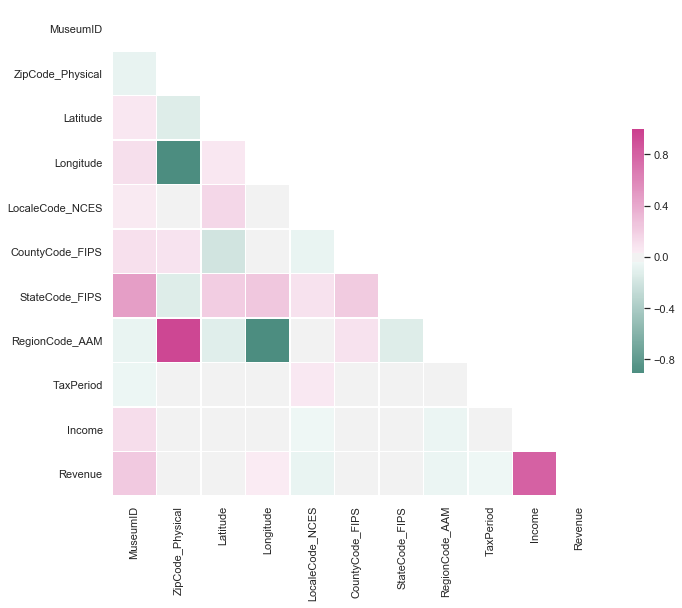

In [9]:
# Visualize correlations with a heatmap

# set background color
sns.set(style="white")

# Compute the correlation matrix
corr = museums.corr() # outputed as a pandas DataFrame

# Generate a mask for the upper triangle
# Since the matrix is symmetric, we just need one half of the coefficients
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(170, -20, n=10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
#sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0, square=True, linewidths=.5, cbar_kws={"shrink": .5})
sns.heatmap(corr, mask=mask, cmap=cmap, center=0, square=True, linewidths=.5, cbar_kws={"shrink": .5})

`Museum ID` was not randomly assigned, but seems to have been defined acording to the museum's location.
`Longitude` is naturally strongly correlated to the ZIP and Region Codes... in fact we have partly redundant information here. 
It also makes sense that `Revenue` and `Income` have a strong positive correlation. So far no big surprise.

In [10]:
# Get a comprehensive overview of numerical columns
# categorical columns can be added too (optional)
museums.describe()

,MuseumID,ZipCode_Physical,Latitude,Longitude,LocaleCode_NCES,CountyCode_FIPS,StateCode_FIPS,RegionCode_AAM,TaxPeriod,Income,Revenue
count,3.307200e+04,9221.000000,33007.000000,33007.000000,32995.000000,30536.000000,33071.000000,33072.000000,23280.000000,2.296100e+04,2.229000e+04
mean,8.403812e+09,47805.644616,38.925372,-90.816757,2.505834,85.701926,29.065828,3.670083,201347.458548,1.069682e+08,2.097605e+07
std,2.662542e+06,30210.265032,5.126213,16.489087,1.211841,105.668318,15.431254,1.539274,67.670742,2.509287e+09,2.485197e+08
min,8.400100e+09,1002.000000,0.000000,-166.541260,1.000000,1.000000,1.000000,1.000000,199906.000000,-9.230000e+02,-2.127393e+06
25%,8.403600e+09,20180.000000,41.034565,-82.197075,1.000000,25.000000,35.500000,4.000000,201408.000000,0.000000e+00,0.000000e+00
50%,8.404801e+09,47448.000000,42.237490,-77.616550,2.000000,61.000000,42.000000,5.000000,201312.000000,8.781000e+03,3.307000e+03
75%,8.401801e+09,74743.000000,35.567720,-97.651155,4.000000,109.000000,17.000000,2.000000,201312.000000,2.163770e+05,1.676960e+05
max,8.409504e+09,99901.000000,70.669760,0.000000,4.000000,840.000000,90.000000,6.000000,201504.000000,8.318144e+10,5.840349e+09


Looking at the `count` row we see that there are a lot of missing values in the Zip Code column... not a reason to worry though : FIPS codes, longitude and latitude are enough for our geospatial analysis.`Income` and `Revenue` are quite well documented but there are missing values in the `TaxPeriod` column. In fact not all rows have been updated recently so not all incomes and revenues date back to the same year. We could either filter rows by `TaxPeriod` or ignore it in a first time, assuming that income and revenues of museums are stable over time.

__Clean the data and select features__

* Keep only the columns we need

For our use case, we want to keep only the ID column, Museum category, Longitude, Latitude, State name and FIPS.

* Filter NaN values in Longitude and Latitude

We want to create a new table by filtering the rows of the original table. We keep the rows only if longitude and latitude are documented. When defining the table we only select the above cited columns.

Option 1: as permanent table

> idadb.ida_query('DROP TABLE IF EXISTS MUSEUMS_PREPARED')

> idadb.ida_query('CREATE TABLE MUSEUMS_PREPARED AS (SELECT "MuseumID", "MuseumType", "State_Physical", "Latitude", "Longitude", "StateCode_FIPS" FROM BLUADMIN.MUSEUMS_DF WHERE "Longitude" IS NOT NULL AND "Latitude" IS NOT NULL) WITH DATA')

Option 2: as temp view only

> idadb.ida_query('DROP VIEW TEMP_MUSEUMS_PREPARED')

> idadb.ida_query('CREATE VIEW TEMP_MUSEUMS_PREPARED AS (SELECT "MuseumID", "MuseumType", "State_Physical", "Latitude", "Longitude", "StateCode_FIPS" FROM BLUADMIN.MUSEUMS_DF WHERE "Longitude" IS NOT NULL AND "Latitude" IS NOT NULL)')

Option 3: directly modify the original Db2 table

> idadb.ida_query('DELETE FROM MUSEUMS_DF WHERE "Longitude" IS NULL OR "Latitude" IS NULL')

In [11]:
# Here with option 3: directly modify the original Db2 table
idadb.ida_query('DELETE FROM MUSEUMS_DF WHERE "Longitude" IS NULL OR "Latitude" IS NULL')

From now on, we will focus on the geospatial and categorical features. We will explore the geospatial functionalities of ibmdbpy by recommending American point of interest.

## 3. Convert the data into an IdaGeoDataFrame for geospatial analysis

To be able to perform geospatial analysis, we first have to convert our data into the right format, i.e. an IdaGeoDataFrame.

So far, we have used Pandas-like functionalities to analyze our data. But since we have geographical features, we would also like to perform a geospatial analysis. Ibmdbpy provides a wrapper for spatial functions which translates geopandas-like syntax into SQL and uses a middleware API to send it to your database (here connected through JDBC) for execution. For more details, please refer to the ibmdbpy documentation [here](https://pythonhosted.org/ibmdbpy/start.html).

__Create an IdaGeoDataFrame with an SQL query__

So far we have an IdaDataFrame, not an IdaGeoDataFame! We need to transform our geospatial features first.

But how does it work ?

To have an IdaGeoDataFrame, you need a column of a particular type : a geometry column. This is also true for geopandas: a GeoDataFrame is a normal Pandas DataFrame plus a special column defined as *geometry*. A specific data type is associated to the geometry column. ST_Geometry is the general type, it has several subtypes :

        ST_Point / ST_MultiPoint
        ST_Linestring / ST_MultiLineString
        ST_Polygon / ST_MultiPolygon
        
It enables you to define various geographical objects such as geographical points, roads, surfaces and so on. But how do we define such a geometry column in the first place?

These geometric objects are actually Db2 spatial objects following OGC guidelines... and you can define a geometry column in your Db2 table via a few lines of SQL. Here you have a `Longitude` and a `Latitude` column... this is enough to define a geospatial point. Here are the SQL statements you need to create a new table with geospatial properties. We will execute them for you inside the notebook by using the `idadb.ida_query()` functio, so no need to open the Db2 console.


> SET CURRENT FUNCTION PATH = CURRENT FUNCTION PATH, db2gse;

> CREATE TABLE GEO_MUSEUMS (id BIGINT, geom db2gse.ST_Point, MuseumType VARCHAR(50), State_Physical VARCHAR(5), StateCode_FIPS DOUBLE, Income DOUBLE, Revenue DOUBLE) 
ORGANIZE BY ROW;

> INSERT INTO geo_museums(id, geom, MuseumType, State_Physical, StateCode_FIPS, Income, Revenue)
SELECT "MuseumID", db2gse.ST_Point("Longitude", "Latitude", 1), "MuseumType", "State_Physical", "StateCode_FIPS", "Income", "Revenue" FROM MUSEUMS_DF;

Note : In the case of geospatial data, Db2 only supports tables organized by rows, in opposition to tables organized by columns. Note the ORGANIZE BY ROW statement when creating a table with geospatial data types.

In [12]:
idadb.ida_query('SET CURRENT FUNCTION PATH = CURRENT FUNCTION PATH, db2gse') # to comment out if already done
idadb.ida_query('DROP TABLE IF EXISTS GEO_MUSEUMS')
idadb.ida_query('CREATE TABLE GEO_MUSEUMS (id BIGINT, geom db2gse.ST_Point, MuseumType VARCHAR(50), MuseumName VARCHAR(200)) ORGANIZE BY ROW')
idadb.ida_query('INSERT INTO geo_museums(id, geom, MuseumType, MuseumName) SELECT "MuseumID", db2gse.ST_Point("Longitude", "Latitude", 1), "MuseumType", "MuseumName" FROM MUSEUMS_DF')

In [13]:
# Take a look at the table you have just created
idageodf = IdaGeoDataFrame(idadb, "GEO_MUSEUMS", geometry = 'GEOM', indexer = "ID")
idageodf.head()

/Users/eva.feillet/.local/lib/python3.7/site-packages/jaydebeapi/__init__.py:250: UserWarning: No type mapping for JDBC type 'STRUCT' (constant value 2002). Using None as a default type_code.
  "Using None as a default type_code." % (type_name, jdbc_type_const))


,ID,GEOM,MUSEUMTYPE,MUSEUMNAME
0,8400100001,POINT (-87.505100 33.295310),GENERAL MUSEUM,WESTERVELT-WARNER MUSEUM OF AMERICAN ART
1,8400100002,POINT (-85.719780 31.349360),GENERAL MUSEUM,U. S. ARMY AVIATION MUSEUM
2,8400100004,POINT (-86.628410 34.713800),GENERAL MUSEUM,U.S. SPACE & ROCKET CENTER
3,8400100005,POINT (-85.955410 32.943940),GENERAL MUSEUM,WELLBORN MUSCLECAR MUSEUM
4,8400100007,POINT (-88.044830 30.690950),GENERAL MUSEUM,USS ALABAMA BATTLESHIP


__Notes about IdaGeoDataFrames__

* Create an IdaGeoDataFrame from an existing IdaDataFrame

You can create an IdaGeoDataFrame from an existing IdaDataFrame if it has an eligible geometry column

In [14]:
# Open the newly created table as IdaDataFrame
# Convert it into an IdaGeoDataFrame

geo_museums = IdaDataFrame(idadb, 'GEO_MUSEUMS', indexer = "ID")
geo_museums = IdaGeoDataFrame.from_IdaDataFrame(geo_museums)
geo_museums.head()

,ID,GEOM,MUSEUMTYPE,MUSEUMNAME
0,8400100001,POINT (-87.505100 33.295310),GENERAL MUSEUM,WESTERVELT-WARNER MUSEUM OF AMERICAN ART
1,8400100002,POINT (-85.719780 31.349360),GENERAL MUSEUM,U. S. ARMY AVIATION MUSEUM
2,8400100004,POINT (-86.628410 34.713800),GENERAL MUSEUM,U.S. SPACE & ROCKET CENTER
3,8400100005,POINT (-85.955410 32.943940),GENERAL MUSEUM,WELLBORN MUSCLECAR MUSEUM
4,8400100007,POINT (-88.044830 30.690950),GENERAL MUSEUM,USS ALABAMA BATTLESHIP


* Defining the geometry column.

This would raise an error... because the geometry attribute has not been set yet.
> geo_museums.geometry
     
     AttributeError: Geometry property has not been set yet. Use set_geometry method to set it.
     
In fact, although the table has been opened as an IdaGeoDataFrame, the geometry column is not automatically detected and attributed! You need to set it. This is useful because there might be several columns with a ST_GEOMETRY type and ibmdbpy functions can take up to two of such columns as argument, so you have to specify which one(s).

In [15]:
geo_museums.set_geometry('GEOM')
type(idageodf.geometry)

ibmdbpy.geoSeries.IdaGeoSeries

__Visualization__

After you have processed the data with ibmdbpy, you can go back to a DataFrame or GeoDataFrame for visualization.

In [16]:
# Note: you can't directly feed in the geometry column to the graph
geo_df=idageodf['GEOM'].as_dataframe()
geo_df.head()
print(geo_df.dtype)
print('Comment: Points not read as tuple of coordinates! Data transformation needed.')

object
Comment: Points not read as tuple of coordinates! Data transformation needed.


You can easily extract back coordinates from a geometry column, here with the `.x()` and `.y()` functions which rely on the DB2 Spatial Extender `ST_X()` and `ST_Y()` functions. Of course here you could strike back to the `Longitude` and `Latitude` columns of the original dataframe, but this is not always the case and you would need to convert them to a geometry type anyway because values are originally seen as floats. So let's see how it works.

In [17]:
# Data transformation for visualization

idageodf['X'] = idageodf.x() # Using the spatial function ST_X and ST_Y to extract the coordinates
idageodf['Y'] = idageodf.y()
pdgeodf = idageodf[['X','Y']].as_dataframe()

geometry = [Point(xy) for xy in zip(pdgeodf['X'],pdgeodf['Y'])]
# df = df.dropna(subset=['Longitude', 'Latitude']) if you want all the original columns, use df in place of pdgeodf
pdgeodf = geopandas.GeoDataFrame(pdgeodf, geometry = geometry)

Text(0.5, 1, 'Tourism opportunities in the USA')

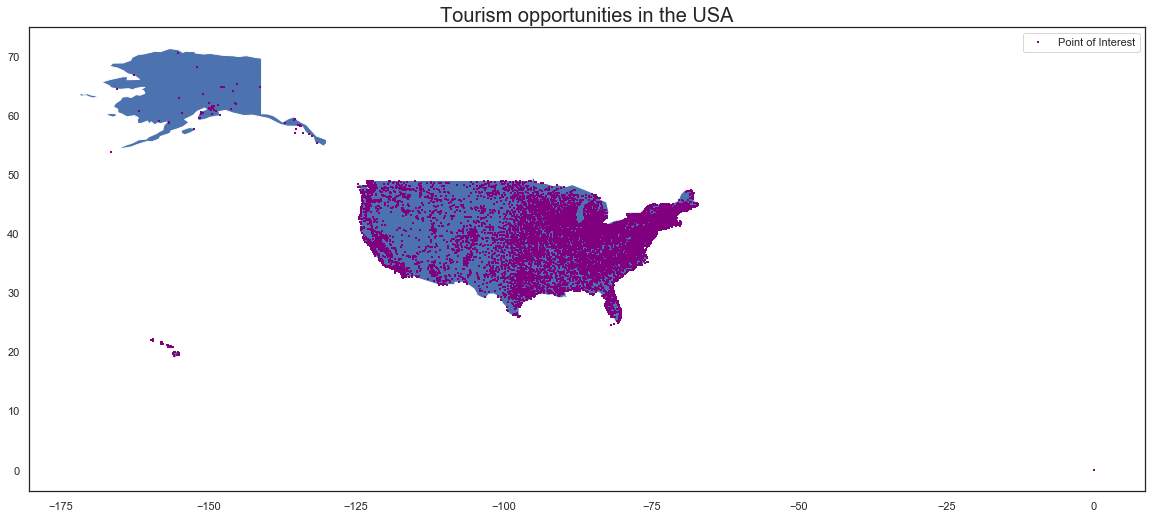

In [18]:
# Load map of the world
world = geopandas.read_file(geopandas.datasets.get_path('naturalearth_lowres'))
#Isolate the map of the United States
usa_bis=world[world['iso_a3'] == 'USA']

# Define the figure
fig, ax = plt.subplots(figsize=(20, 10))

# Plot the underlying map
usa_bis.plot(ax=ax)
# Plot the US points of interest
pdgeodf.plot(ax=ax, markersize=2, marker='+', color='purple')

legend=['Point of Interest']
plt.legend(legend)
plt.title('Tourism opportunities in the USA', size=20)

* Zoom in and visualize museum types

In [19]:
# Filter rows on longitude and latitude
# syntax example : idadf[(idadf['col1'] < val1) & (idadf['col2'] > val2)]

filtered_idageodf = idageodf[(idageodf['X']>-125) & (idageodf['X']<-60) & (idageodf['Y']>25) & (idageodf['Y']>-50)]

In [20]:
# Conversion to GeoDataFrame

# to Pandas DataFrame
filtered_pdgeodf = filtered_idageodf.as_dataframe()
# geometry column
geometry2 = [Point(xy) for xy in zip(filtered_pdgeodf['X'],filtered_pdgeodf['Y'])]
#  to pandas GeoDataFrame
filtered_pdgeodf = geopandas.GeoDataFrame(filtered_pdgeodf, geometry = geometry2)

In [21]:
## categories ## --> useful for visulization with color code
filtered_pdgeodf.MUSEUMTYPE = pandas.Categorical(filtered_pdgeodf.MUSEUMTYPE)
filtered_pdgeodf['code'] = filtered_pdgeodf.MUSEUMTYPE.cat.codes
filtered_pdgeodf.head(10)

,ID,GEOM,MUSEUMTYPE,MUSEUMNAME,X,Y,geometry,code
0,8409501724,POINT (-89.554580 30.812700),GENERAL MUSEUM,PEARL RIVER COMMUNITY COLLEGE MUSEUM,-89.55458,30.81270,POINT (-89.55458 30.81270000000001),3
1,8402800144,POINT (-89.655710 30.535020),HISTORIC PRESERVATION,PEARL RIVER COUNTY HISTORICAL SOCIETY,-89.65571,30.53502,POINT (-89.65571 30.53502),4
2,8402800069,POINT (-90.032010 32.306800),GENERAL MUSEUM,PEARL RIVER WOODCARVERS GUILD,-90.03201,32.30680,POINT (-90.03201 32.3068),3
3,8402800012,POINT (-89.114590 32.767610),HISTORIC PRESERVATION,PHILADELPHIA HISTORICAL MUSEUM,-89.11459,32.76761,POINT (-89.11459000000001 32.76761),4
4,8409401027,POINT (-90.882950 32.342460),CHILDREN'S MUSEUM,PIGS-IN-FLIGHT,-90.88295,32.34246,POINT (-90.88294999999999 32.34246),2
5,8402800085,POINT (-91.400130 31.562160),HISTORIC PRESERVATION,PILGRIMAGE HISTORICAL ASSOCIATION,-91.40013,31.56216,POINT (-91.40013 31.56216000000001),4
6,8402800247,POINT (-90.172900 32.158300),HISTORIC PRESERVATION,PINOLA HISTORICAL SOCIETY,-90.17290,32.15830,POINT (-90.1729 32.1583),4
7,8402800185,POINT (-89.981000 34.779760),GENERAL MUSEUM,PIONEER AMERICANS HALL FAME,-89.98100,34.77976,POINT (-89.98099999999999 34.77976),3
8,8402800017,POINT (-88.869920 30.392940),HISTORIC PRESERVATION,PLEASANT REED HOUSE,-88.86992,30.39294,POINT (-88.86991999999999 30.39294),4
9,8402800192,POINT (-89.000470 34.263070),HISTORIC PRESERVATION,PONTOTOC COUNTY HISTORICAL SOCIETY,-89.00047,34.26307,POINT (-89.00047000000001 34.26307),4


In [22]:
# load map of the USA

import subprocess
subprocess.check_call("wget -nc https://www2.census.gov/geo/tiger/GENZ2018/shp/cb_2018_us_state_5m.zip", shell=True)
subprocess.check_call("unzip cb_2018_us_state_5m.zip", shell=True)

usa = geopandas.read_file("cb_2018_us_state_5m.shp")

# cut out some states in order to be able to zoom in
for stusps in ['HI', 'VI', 'GU', 'MP', 'AS', 'PR', 'AK']: 
    usa = usa[usa['STUSPS'] != stusps]

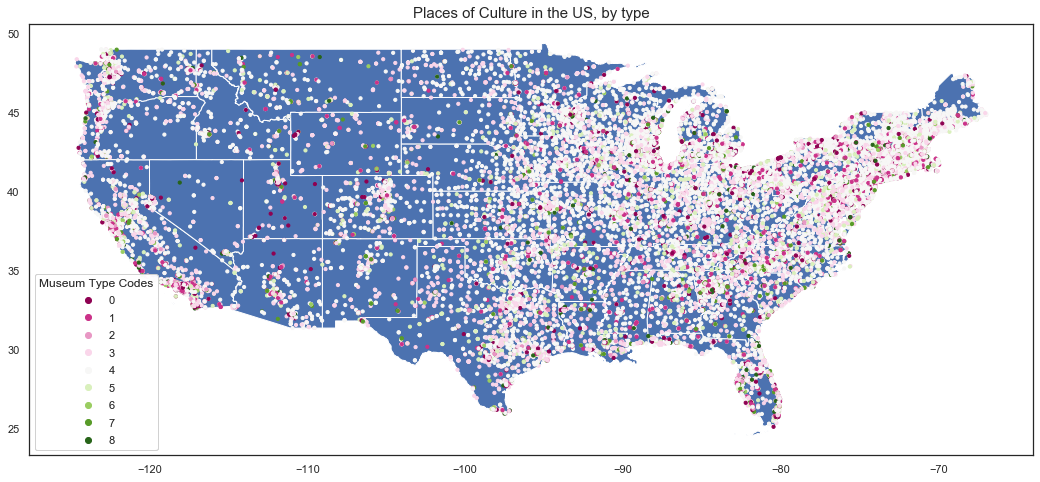

In [23]:
# scatter plot with museum type color code

x, y = filtered_pdgeodf.X, filtered_pdgeodf.Y
c = pandas.to_numeric(filtered_pdgeodf.code)
# s could be revenue or income

fig, ax = plt.subplots(figsize = (18,16))
usa.plot(ax=ax)
scatter = ax.scatter(x, y, c=c, s=10, cmap = 'PiYG')

# produce a legend with the unique colors from the scatter
legend1 = ax.legend(*scatter.legend_elements(),
                    loc="lower left", title="Museum Type Codes")
ax.add_artist(legend1)
plt.title("Places of Culture in the US, by type", size =15)
plt.show()

In [24]:
dict( enumerate(filtered_pdgeodf['MUSEUMTYPE'].cat.categories ))

{0: 'ARBORETUM, BOTANICAL GARDEN, OR NATURE CENTER',
 1: 'ART MUSEUM',
 2: "CHILDREN'S MUSEUM",
 3: 'GENERAL MUSEUM',
 4: 'HISTORIC PRESERVATION',
 5: 'HISTORY MUSEUM',
 6: 'NATURAL HISTORY MUSEUM',
 7: 'SCIENCE & TECHNOLOGY MUSEUM OR PLANETARIUM',
 8: 'ZOO, AQUARIUM, OR WILDLIFE CONSERVATION'}

___
__Congratulations!__ You reached the end of this notebook. Before going to the next notebook of this series, close the current connection to Db2 Warehouse.

In [25]:
idadb.close()
# idadb.reconnect() if connection closed and you want to restore the connection.

Connection closed.


## Wrap-up 

Congratulations! You now know how to:
* write a table to Db2 using ibmdbpy;
* open and create IdaDataFrames and IdaGeoDataFrames locally;
* directly query the database with the idadb.ida_query() function;
* use ibmdbpy functionalities in common, useful cases:
* convert a Pandas (Geo)DataFrame into an ibmdbpy Ida(Geo)DataFrame and vice versa.

## Where to go from here?

Go to the next notebook [Geospatial recommendation](./ibmdbpy_Museums_DataAnalysis_2-geospatial.ipynb).

If you haven't already done so, we encourage you to have a look at the **Getting started** notebooks also available in this repository. See also the **Machine learning** notebooks.

* Getting started with ibmdbpy:
        
    [Basics](../GettingStarted/ibmdbpy_GettingStarted_1-basics.ipynb)

    [GeoBasics](../GettingStarted/ibmdbpy_GettingStarted_2-geo_basics.ipynb)

    [Extensive Guide](../GettingStarted/ibmdbpy_GettingStarted_3-geo_guide.ipynb)


* Machine learning with ibmdbpy: 
        
    [Naïve Bayes](../MachineLearning/ibmdbpy_NaiveBayes.ipynb)

    [KMeans](../GettingStarted/ibmdbpy_GettingStarted_1-basics.ipynb) 
    
    [Association Rules Mining](../MachineLearning/ibmdbpy_AssociationRulesMining.ipynb)


____

__Authors__

Eva Feillet - ML intern, IBM Cloud and Cognitive Software @ IBM Lab in Böblingen, Germany